In [1]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from transformers import pipeline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Génération d'un dataset complet pour l'analyse des articles sur l'agriculture biologique

## Objectif
Le code suivant vise à construire un dataset contenant des articles du **HuffPost** traitant de l'agriculture biologique. Chaque article sera enrichi de plusieurs informations, notamment une date, les phrases clés où le mot *bio* ou *biologique* a été trouvé, ainsi qu'une valeur de sentiment entre 0 et 1 indiquant si l'article est globalement positif ou négatif vis-à-vis de l'agriculture biologique.

## Méthodologie
1. **Collecte des articles** :  
   Les articles présents dans la section *Agriculture* du HuffPost sont collectés. Les données initiales extraites incluent le titre, le résumé et l'URL de chaque article.

2. **Extraction du contenu et filtrage par mots-clés** :  
   À partir des URL, le contenu complet des articles est récupéré et stocké dans la colonne **Paragraphs**. Un filtrage est ensuite effectué pour identifier les articles contenant les mots-clés *bio* (avec un espace pour éviter des mots comme biodégradable) ou *agriculture biologique*.  
   Les phrases ou paragraphes où ces termes apparaissent sont extraits et enregistrés dans la colonne **Found_in**.

3. **Analyse de sentiment** :  
   Une analyse de sentiment est réalisée sur chaque élément présent dans la colonne **Found_in** (phrases ou paragraphes pertinents). Une moyenne des scores obtenus est calculée pour chaque article, donnant une valeur comprise entre 0 et 1 :  
   - Proche de 1 : L'article est globalement positif vis-à-vis de l'agriculture biologique.  
   - Proche de 0 : L'article est globalement négatif vis-à-vis de l'agriculture biologique.

4. **Structure du dataset** :  
   Le dataset final contiendra les colonnes suivantes :  
   - **Title** : Le titre de l'article.  
   - **Summary** : Un résumé concis de l'article.  
   - **URL** : Le lien vers l'article pour une consultation détaillée.  
   - **Paragraphs** : Le contenu complet de l'article.  
   - **Date** : La date de publication de l'article.  
   - **Found_in** : Les phrases ou paragraphes où les mots *bio* ou *biologique* ont été détectés.  
   - **Average_Sentiment_Score** : Une valeur entre 0 et 1 représentant la tonalité générale de l'article.  

## Résultat attendu
Ce dataset permettra de suivre l'évolution de la perception médiatique de l'agriculture biologique.


In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",  # Supporte la compression
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",  # Pour indiquer le support de HTTPS et les mises à jour
    "Cache-Control": "max-age=0",  # Pour forcer le rechargement des ressources
    "TE": "Trailers"  # Support de la transmission avec les trailers HTTP/2
}


# Construction du dataset 'title' , 'description' , 'url' avec tout les articles traitant d'agriculture

In [3]:
def scrape_all_page(url):
    all_articles = []  # Liste des articles collectés
    seen_articles = set()  # Ensemble pour éviter les doublons d'URL

    try:
        # Envoyer une requête HTTP pour récupérer la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles via la classe "articlePreview-content"
            articles = soup.find_all("div", class_="articlePreview-content")
            
            for article in articles:
                # Extraire le lien de l'article
                link_element = article.find("a", href=True)
                article_url = f"https://www.huffingtonpost.fr{link_element['href']}" if link_element else ""

                # Extraire le titre
                title_element = article.find("div", class_="title")
                title_text = title_element.find("h2").get_text(strip=True) if title_element else ""

                # Extraire la description
                description_element = article.find("div", class_="articlePreview-chapo")
                description_text = description_element.get_text(strip=True) if description_element else ""

                # Vérifier si l'article est déjà collecté
                if article_url and article_url not in seen_articles:
                    # Ajouter l'article sous forme de dictionnaire
                    all_articles.append({
                        "title": title_text,
                        "description": description_text,
                        "url": article_url
                    })
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []


In [4]:
def scrape_all_pages(base_url, total_pages):
    all_articles = []  # Liste pour collecter tous les articles

    for page_num in range(1, total_pages + 1):
        # Construire l'URL pour chaque page
        if page_num == 1:
            url = base_url  # La première page n'a pas de suffixe "?page="
        else:
            url = f"{base_url}?page={page_num}"
        
        print(f"Scraping de la page : {url}")
        articles = scrape_all_page(url)  # Appeler la fonction pour une page
        all_articles.extend(articles)  # Ajouter les articles collectés

        print(f"Page {page_num} : {len(articles)} articles collectés.")

    print(f"Scraping terminé : {len(all_articles)} articles collectés au total.")
    return all_articles


In [5]:
# Fonction pour exporter les résultats en CSV
def export_to_csv_1(dataset, filename="articles_dataset.csv"):
    # Ouvrir le fichier CSV en mode écriture
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        # Définir les noms des colonnes (en-têtes)
        fieldnames = ["Title", "Description", "URL"]
        
        # Créer un objet DictWriter pour écrire dans le fichier
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Écrire les en-têtes dans le fichier
        writer.writeheader()
        
        # Écrire chaque ligne de données dans le fichier
        for data in dataset:
            # Formatage des données pour correspondre aux en-têtes
            writer.writerow({
                "Title": data["title"],
                "Description": data["description"],
                "URL": data["url"]
            })

    print(f"Les résultats ont été sauvegardés dans '{filename}'.")


32sec

In [ ]:
base_url = "https://www.huffingtonpost.fr/agriculture/"
total_pages = 37

# Scraper tous les articles des 37 pages
all_articles = scrape_all_pages(base_url, total_pages)

# Sauvegarder les résultats dans un fichier CSV
export_to_csv_1(all_articles, "agriculture_huffpost.csv")


Scraping de la page : https://www.huffingtonpost.fr/agriculture/
Page 1 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=2


Page 2 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=3
Page 3 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=4
Page 4 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=5
Page 5 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=6
Page 6 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=7
Page 7 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=8
Page 8 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=9
Page 9 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=10
Page 10 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=11
Page 11 : 30 articles collectés.
Scraping de la page : https:

In [7]:
all_articles[:1]

[{'title': 'Pour remobiliser sur leurs revendications, des agriculteurs paradent aux couleurs de Noël',
  'description': 'De la Normandie à l’Occitanie, des agriculteurs affiliés aux syndicats majoritaires FNSEA-JA, décorent leur tracteur pour continuer de faire vivre leur mouvement en cette période de fêtes.',
  'url': 'https://www.huffingtonpost.fr/france/video/colere-agricole-des-agriculteurs-paradent-aux-couleurs-de-noel-pour-remobiliser-sur-leurs-revendications_243925.html'}]

## Filtrage du dataset pour ne conserver que les articles pertinents

On filtre le dataset afin qu'il ne contienne que les articles mentionnant explicitement les termes *"bio "* (avec un espace pour exclure des mots comme *biodégradable*) ou *"biologique"*. 

- **Colonne `Paragraphs`** : Cette colonne est renseignée avec l'ensemble des paragraphes de chaque article.  
- **Colonne `Found_in`** : Cette colonne contient une liste des paragraphes, du titre ou du résumé où l'un des termes recherchés (*"bio "* ou *"biologique"*) a été détecté. Cela permet d'isoler les occurrences pertinentes et de fournir un contexte textuel clair pour chaque mention des termes.


In [8]:
def fetch_article_detail(articles):
    """
    Enrichit une liste d'articles avec les paragraphes et la date de publication.
    
    :param articles: Liste de dictionnaires contenant 'title', 'description' et 'url' pour chaque article.
    :return: Liste enrichie avec les 'paragraphs' et 'publication_date'.
    """
    articles_enrichis = []
    
    for article in articles:
        try:
            # Extraction des informations de l'article
            titre = article.get("title")
            resume = article.get("description")
            url = article.get("url")

            # Récupération de la page HTML
            response = requests.get(url)
            response.raise_for_status()  # Vérifie que la requête est réussie
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extraction des paragraphes
            paragraphes = [
                p.get_text(strip=True) for p in soup.find_all('p', class_='asset asset-text')
            ]
            
            # Extraction de la date de publication
            date_element = soup.find('time', class_='article-metas')
            if date_element:
                date_publication = date_element.find('span', class_='article-metas__date')
                date_publication = date_publication.get_text(strip=True) if date_publication else "Date inconnue"
            else:
                date_publication = "Date inconnue"
            
            # Ajouter les données enrichies à l'article
            articles_enrichis.append({
                "title": titre,
                "description": resume,
                "url": url,
                "paragraphs": paragraphes,
                "publication_date": date_publication
            })
        
        except Exception as e:
            # En cas d'erreur, log et continuer
            print(f"Erreur pour l'article : {titre} ({url}) - {e}")
            articles_enrichis.append({
                "title": titre,
                "description": resume,
                "url": url,
                "paragraphs": [],
                "publication_date": "Erreur lors de l'extraction"
            })
    
    return articles_enrichis


In [28]:
# Fonction pour vérifier si "bio" est dans le texte et retourner les phrases contenant "bio"
def find_sentences_with_bio(text):
    text = text.lower()
    sentences = text.split('.')  # Diviser le texte en phrases
    bio_sentences = [sentence.strip() for sentence in sentences if 'bio ' in sentence or 'biologique' in sentence]
    return bio_sentences

# Fonction pour filtrer les articles contenant le mot "bio" et ajouter les phrases correspondantes
def filter_articles_with_bio(dataset):
    filtered_articles = []
    total_articles = len(dataset)

    # Initialiser tqdm pour la boucle avec un calcul du temps estimé
    start_time = time.time()  # Démarrer le chronomètre

    for i, article in tqdm(enumerate(dataset), total=total_articles, desc="Filtrage des articles", unit="article"):
        bio_sentences = []

        # Vérifier si "bio" est dans le titre
        bio_sentences += find_sentences_with_bio(article.get("title", ""))

        # Vérifier si "bio" est dans le résumé
        bio_sentences += find_sentences_with_bio(article.get("description", ""))

        # Vérifier chaque paragraphe
        for paragraph in article.get("paragraphs", []):
            bio_sentences += find_sentences_with_bio(paragraph)

        if bio_sentences:  # Ajouter seulement si des phrases contenant "bio" ont été trouvées
            article_with_bio = article.copy()
            article_with_bio["bio_sentences"] = bio_sentences  # Ajouter les phrases contenant "bio"
            filtered_articles.append(article_with_bio)

        # Calculer et afficher le temps estimé restant
        elapsed_time = time.time() - start_time  # Temps écoulé
        progress = (i + 1) / total_articles  # Progression
        estimated_time_left = elapsed_time / progress - elapsed_time  # Temps estimé restant
        print(f"\rProgression : {progress * 100:.2f}% - Temps restant estimé : {estimated_time_left / 60:.2f} minutes", end="")

    print()  # Pour un retour à la ligne après l'affichage du progrès
    return filtered_articles


3min

In [29]:
# Scraper les détails de chaque article dans `all_articles`
detailed_articles = fetch_article_detail(all_articles)

In [ ]:
detailed_articles[0]

[{'title': 'Pour remobiliser sur leurs revendications, des agriculteurs paradent aux couleurs de Noël',
  'description': 'De la Normandie à l’Occitanie, des agriculteurs affiliés aux syndicats majoritaires FNSEA-JA, décorent leur tracteur pour continuer de faire vivre leur mouvement en cette période de fêtes.',
  'url': 'https://www.huffingtonpost.fr/france/video/colere-agricole-des-agriculteurs-paradent-aux-couleurs-de-noel-pour-remobiliser-sur-leurs-revendications_243925.html',
  'paragraphs': ['AGRICULTURE - Tracteurs«\xa0enguirlandés\xa0». En Vendée, dans le Finistère, dans l’Eure ou encore dans le Lot, les sections départementales des syndicats de la FNSEA et des Jeunes agriculteurs (JA) ont décidé de se mobiliser autrement, en paradant dans les rues avec leur tracteur décoré aux couleurs de Noël. Un moyen de rappeler que leurmouvement de revendications, contrel’accord de libre échange UE-Mercosuret les normes environnementales, entre autres, se maintient malgré les fêtes.',
   '«

In [31]:
# Filtrer les articles contenant le mot "bio"
filtered_articles = filter_articles_with_bio(detailed_articles)



Filtrage des articles: 100%|██████████| 1103/1103 [00:00<00:00, 12221.09article/s]

Progression : 100.00% - Temps restant estimé : 0.00 minutes


In [ ]:

# Charger le modèle de sentiment d'Hugging Face
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    # Utiliser le modèle de sentiment pour prédire le sentiment
    result = sentiment_analyzer(text)

    # Le modèle retourne une liste avec un dictionnaire contenant les labels et scores
    sentiment = result[0]
    
    # Convertir le label en score : 'LABEL_1' est positif, 'LABEL_0' est négatif
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif


Device set to use cpu


Nous allons maintenant ajouter une valeur comprise entre 0 et 1 à chaque article, reflétant son ton vis-à-vis du bio (positif ou négatif), en utilisant le modèle d'analyse de sentiment proposé par **Hugging Face**.  

Cependant, cette méthode présente une limite importante : elle évalue le sentiment global d'une phrase sans prendre en compte le contexte spécifique au bio. Par exemple, une phrase comme *"Il n'y a pas assez de parcelles bio en France"* serait considérée comme négative, bien qu'elle ne critique pas directement le bio mais plutôt son insuffisance.  

Une approche alternative aurait consisté à utiliser un modèle de langage large (LLM) comme GPT, avec des appels spécifiques contenant des prompts contextualisés. Cela aurait permis de mieux cerner les nuances et d'exclure les phrases où le ton négatif ou positif n'est pas réellement dirigé vers l'agriculture biologique. Toutefois, en raison des contraintes liées à l'absence de GPU et au nombre limité d'appels API, nous avons opté pour la solution basée sur **Hugging Face**, qui reste adaptée et efficace dans ce contexte.

In [33]:
# Fonction pour appliquer l'analyse de sentiment à chaque article dans la liste
def add_sentiment_score_to_articles(articles):
    """
    Applique l'analyse de sentiment sur chaque phrase ajoutée à l'article
    et ajoute la moyenne des scores de sentiment à chaque article.
    
    :param articles: Liste de dictionnaires contenant les articles enrichis avec des clés comme 'title', 'description', 'url', 'paragraphs', 'bio_sentences'.
    :return: Liste de dictionnaires enrichis avec le score de sentiment moyen.
    """
    for article in articles:
        # Extraire les phrases contenant "bio" (clé 'bio_sentences')
        sentences = article.get("bio_sentences", [])

        if sentences:  # Appliquer l'analyse de sentiment uniquement si des phrases contenant "bio" sont présentes
            # Appliquer l'analyse de sentiment à chaque phrase
            sentiment_scores = [analyze_sentiment_bio_with_model(sentence) for sentence in sentences]

            # Calculer la moyenne des scores de sentiment
            average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

            # Ajouter le score de sentiment moyen au dictionnaire
            article["sentiment_score"] = average_score
        else:
            # Si aucune phrase contenant "bio" n'est trouvée, définir le score comme 0
            article["sentiment_score"] = 0

    return articles


9min5

In [34]:
final_data = add_sentiment_score_to_articles(filtered_articles)

In [35]:
final_data[0]

{'title': 'Pourquoi les agriculteurs menacent de ressortir les tracteurs',
 'description': 'Les aides européennes pour les agriculteurs en bio ou engagés pour la transition écologique accusent plusieurs mois de retard.',
 'url': 'https://www.huffingtonpost.fr/france/article/agriculteurs-en-colere-pourquoi-les-syndicats-menacent-de-ressortir-les-tracteurs-sans-blocage-pour-l-instant-clx1_235430.html',
 'paragraphs': ['AGRICULTURE - L’art de semer des promesses. Au début de l’année, alors que lacolère des agriculteursse faisait entendre à travers le pays,Gabriel Attals’engageait solennellement à apaiser les tensions en garantissant que«\xa0d’ici le 15\xa0mars, toutes les aides PAC seraient versées sur les comptes bancaires des exploitants\xa0». Quelques semaines plus tard, n’ayant pas tenu ce délai, le ministère de l’Agriculture annonçait que les aides arriveraient finalement au plus tard le 15\xa0juin.',
  'Or ce jour est passé et des milliers de fermes attendent toujours leurs paiement

## On enregistre le csv final

In [36]:
# Fonction pour enregistrer les données au format CSV
def save_to_csv_final(data, filename):
    """
    Enregistre la liste de dictionnaires au format CSV.
    
    :param data: Liste de dictionnaires contenant les données des articles.
    :param filename: Nom du fichier CSV de sortie.
    """
    # Définir les en-têtes en fonction des clés des dictionnaires
    headers = [
        "Title", 
        "Summary", 
        "URL", 
        "Paragraphs", 
        "Date", 
        "Found_in", 
        "Average_Sentiment_Score"
    ]
    
    # Écriture dans le fichier CSV
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        
        # Écrire les en-têtes
        writer.writeheader()
        
        # Écrire les données
        for article in data:
            # Extraire les données à partir du dictionnaire
            row = {
                "Title": article.get("title", ""),
                "Summary": article.get("description", ""),
                "URL": article.get("url", ""),
                "Paragraphs": "\n\n".join(article.get("paragraphs", [])),  # Joindre les paragraphes par des doubles sauts de ligne
                "Date": article.get("publication_date", ""),
                "Found_in": ", ".join(article.get("bio_sentences", [])),  # Joindre les phrases contenant "bio"
                "Average_Sentiment_Score": article.get("sentiment_score", 0)  # Score de sentiment moyen
            }
            writer.writerow(row)

    print(f"Les données ont été enregistrées dans le fichier '{filename}'.")


In [ ]:
save_to_csv_final(final_data,"data_huffpost.csv")

Les données ont été enregistrées dans le fichier 'data_huffpost_.csv'.


In [38]:
final_data[0]

{'title': 'Pourquoi les agriculteurs menacent de ressortir les tracteurs',
 'description': 'Les aides européennes pour les agriculteurs en bio ou engagés pour la transition écologique accusent plusieurs mois de retard.',
 'url': 'https://www.huffingtonpost.fr/france/article/agriculteurs-en-colere-pourquoi-les-syndicats-menacent-de-ressortir-les-tracteurs-sans-blocage-pour-l-instant-clx1_235430.html',
 'paragraphs': ['AGRICULTURE - L’art de semer des promesses. Au début de l’année, alors que lacolère des agriculteursse faisait entendre à travers le pays,Gabriel Attals’engageait solennellement à apaiser les tensions en garantissant que«\xa0d’ici le 15\xa0mars, toutes les aides PAC seraient versées sur les comptes bancaires des exploitants\xa0». Quelques semaines plus tard, n’ayant pas tenu ce délai, le ministère de l’Agriculture annonçait que les aides arriveraient finalement au plus tard le 15\xa0juin.',
  'Or ce jour est passé et des milliers de fermes attendent toujours leurs paiement

## On affiche une visualisation colorimétrique du nombre d'article par mois et de la valeur moyenne de la positivité ou négativité de l'analyse de sentiment. On remarque que les articles ne remontent que à 2012 il n'y a pas de valeurs pour les année de 2000 à 2012 nous ne pouvons donc pas utiliser ces valeurs pour l'indicateur du nombre d'article mais que pour celui de la positivité ou négativité des articles. 

In [46]:
def plot_months_with_color_based_on_score(data):
    """
    Génère un graphique montrant le nombre d'articles par mois, avec une couleur différente pour chaque mois
    en fonction du score moyen des articles de ce mois. Le score est extrait de la clé 'score'.
    
    :param data: Liste de dictionnaires où la date de publication se trouve sous la clé 'publication_date'
                 et le score sous la clé 'score'.
    """
    # Initialisation de dictionnaires pour compter les articles et calculer la somme des scores par mois
    articles_per_month = {}
    scores_per_month = {}

    # Boucle pour extraire les données pertinentes
    for entry in data:
        try:
            date_str = entry.get('publication_date')  # Récupérer la date
            score = entry.get('sentiment_score', 0)  # Récupérer le score (défaut : 0)

            # Vérifier que les deux champs existent
            if not date_str or not isinstance(score, (int, float)):
                continue

            # Conversion de la date au format 'DD/MM/YYYY HH:MM'
            date_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
            
            # Formater la date pour obtenir le mois et l'année (format 'YYYY-MM')
            month_year = date_obj.strftime('%Y-%m')
            
            # Incrémenter le compteur pour le mois et ajouter le score pour le calcul du score moyen
            if month_year not in articles_per_month:
                articles_per_month[month_year] = 0
                scores_per_month[month_year] = 0.0
            articles_per_month[month_year] += 1
            scores_per_month[month_year] += score
        except Exception as e:
            print(f"Erreur de traitement pour l'entrée {entry}: {e}")
            continue

    # Calculer le score moyen par mois
    average_scores = {month: scores_per_month[month] / articles_per_month[month] for month in articles_per_month}

    # Créer une liste de tous les mois de l'année (en format YYYY-MM)
    all_months = pd.date_range(start=min(pd.to_datetime(list(articles_per_month.keys()))), 
                               end=max(pd.to_datetime(list(articles_per_month.keys()))), 
                               freq='MS').strftime('%Y-%m').tolist()

    # Liste des mois avec ou sans articles
    month_labels = []
    month_counts = []
    month_scores = []
    
    # Ajouter des mois manquants (ceux sans articles)
    for month in all_months:
        month_labels.append(month)
        month_counts.append(articles_per_month.get(month, 0))
        month_scores.append(average_scores.get(month, 0))

    # Créer un DataFrame avec les mois, le nombre d'articles et le score moyen
    df = pd.DataFrame({
        'Month': month_labels,
        'Article_Count': month_counts,
        'Average_Score': month_scores
    })

    # Créer une échelle de couleurs pour les scores (de rouge à vert)
    norm = mcolors.Normalize(vmin=min(month_scores), vmax=max(month_scores))
    cmap = plt.colormaps['RdYlGn']  # Palette de couleurs allant de rouge (faible) à vert (élevé)
    
    # Tracer les données
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_colors = [cmap(norm(score)) for score in df['Average_Score']]  # Couleur des barres en fonction du score moyen
    bars = ax.bar(df['Month'], df['Article_Count'], color=bar_colors)

    # Ajouter des labels et un titre
    ax.set_xlabel('Mois', fontsize=12)
    ax.set_ylabel('Nombre d\'Articles', fontsize=12)
    ax.set_title('Nombre d\'Articles par Mois avec Scores Moyens', fontsize=14)

    # Rotation des labels de l'axe X pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)

    # Définir les ticks de l'axe X (positionner les mois)
    tick_positions = range(len(df['Month']))
    ax.set_xticks(tick_positions)

    # Ne mettre l'année qu'une seule fois par année
    ax.set_xticklabels([label if i == 0 or label[:4] != df['Month'][i-1][:4] else '' for i, label in enumerate(df['Month'])])

    # Ajouter une grille
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter une légende de couleur (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Nécessaire pour afficher la légende
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('Score Moyen')

    # Ajustement des marges
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


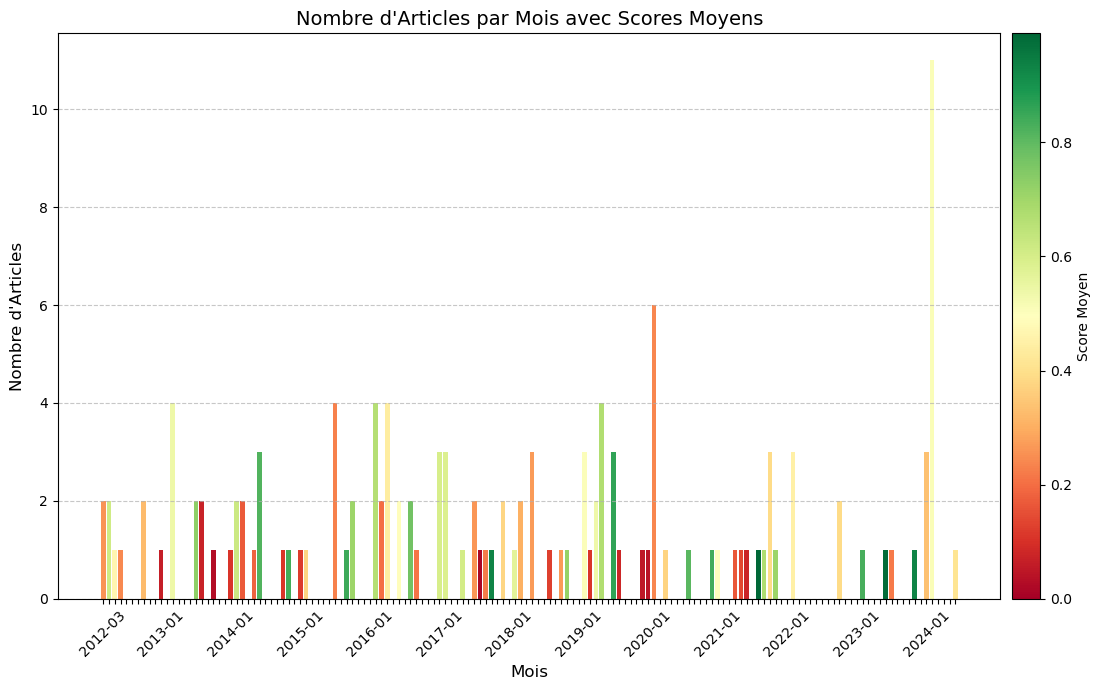

In [47]:
plot_months_with_color_based_on_score(final_data)